In [ ]:
# default_exp core

# module name here

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def _get_ax(line):
    """ returns the direction of the line
    [param] line: tuple or np.array of length 4, where 0,1 is point 1 and 3,4 is point 2
    """
    if np.isclose(line[0],line[2]) and line[1] != line[3]:
        return 1
    else:
        return 0

In [ ]:
assert _get_ax([0,0,200,0]) == 0
assert _get_ax([200,0,0,0]) == 0
assert _get_ax([0,200,0,0]) == 1
assert _get_ax([0,0,0,200]) == 1

In [ ]:
#export
class OneLine(np.ndarray):
    def __init__(self, a):
        super().__init__()
        self.ax=_get_ax(self)
        self.ay= (self.ax+1)%2
        
    def __new__(cls, line):
        return np.asarray(line, dtype=float).view(cls)
        
    def move_xy(self,x,y):
        self +=[x,y,x,y]
        
    def move_in_ax(self, dist):
        self[[self.ax, self.ax+2]] += dist
        
    def move_in_ay(self, dist):
        ay = (self.ax+1)%2
        self[[ay, ay+2]] += dist
        
    def to_points(self):
        return self.reshape(2,2)
    
    def __repr__(self):
        return f"l: {self}, ax: {self.ax}"
    
    def copy(self):
        return OneLine(self)
    
    def plot(self):
        p = self.to_points()
        plt.plot(p[:,0],p[:,1])

In [ ]:
l = OneLine([0,0,1,0])
assert len(l) == 4
assert l.ax==0
assert l.ay==1

l = OneLine([0,0,0,1])
assert len(l) == 4
assert l.ax==1
assert l.ay==0
assert l.dtype == float
assert l.to_points().shape ==(2,2)

l.ax
l[:] = l[[2,3,0,1]]
l

l: [0. 1. 0. 0.], ax: 1

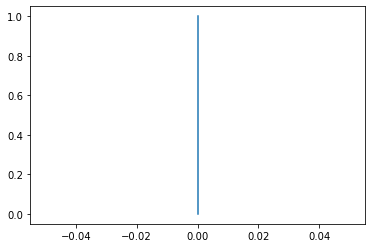

In [ ]:
l.plot()

In [ ]:
#export
def _line2segmented_pointlist(line, min_tab_mm):
    """
    This fuction splits a line into segments that can be used to generate tabs or holes.
    The min_tab_mm tells the minimum tabsize but might adjusts it a bit larger to always make 
    number of tabs an even number so it's symetrical
    \[param] min_tab_mm
    
    \[return]: list of points, shape (number of segments, 2(x,y))
    """
    line=OneLine(line)
    diff =  line[line.ax+2] - line[line.ax]
    if diff<0:
        line[:] = line[[2,3,0,1]]
    num_tabs = int(abs(diff/min_tab_mm))
    if num_tabs%2==0:
        num_tabs -=1
    tab_size= abs(diff/num_tabs)
    all_tabs = np.arange(line[line.ax], line[line.ax+2]+1, tab_size)
    ret = np.zeros((len(all_tabs),2))
    ret[:,line.ax] = all_tabs
    ret[:,line.ay] = line[line.ay]
    return ret

In [ ]:
line = [0, 200, 0,0]
segments = _line2segmented_pointlist(line, 15)
assert len(segments)%2==0
segments

array([[  0.        ,   0.        ],
       [  0.        ,  15.38461538],
       [  0.        ,  30.76923077],
       [  0.        ,  46.15384615],
       [  0.        ,  61.53846154],
       [  0.        ,  76.92307692],
       [  0.        ,  92.30769231],
       [  0.        , 107.69230769],
       [  0.        , 123.07692308],
       [  0.        , 138.46153846],
       [  0.        , 153.84615385],
       [  0.        , 169.23076923],
       [  0.        , 184.61538462],
       [  0.        , 200.        ]])

In [ ]:
def plot_lines(lines):
    for l in lines:
        l = l.reshape(2,2)
        plt.plot(l[:,0], l[:,1])

In [ ]:
#export
def _segments_to_tabs(segments, ax, tabsize):
    """
    genrates tabs from a segmented point list
    """
    arr_x = np.repeat(segments[:,ax], 2)
    arr_y = np.tile([0,0, tabsize, tabsize], len(segments)//2+1)[1:-3]
    ret = np.zeros((len(arr_x),2))
    ret[:,ax] = arr_x
    ay =(ax+1)%2
    ret[:,ay] = arr_y
    points = ret[1:-1,:]
    
    lines = np.hstack([points[:-1], points[1:]])
    if tabsize <0:
        lines[:,[ay, ay+2]] -= tabsize
        
    return lines

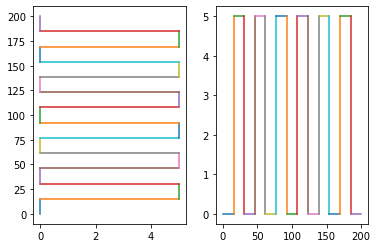

In [ ]:
line = OneLine([0, 200, 0,0])
segments= _line2segmented_pointlist(line, 15)
tabs = _segments_to_tabs(segments, line.ax, -5)
plt.subplot(1,2,1)
plot_lines(tabs)
assert np.min(tabs) == 0.0

line = OneLine([ 200,0,  0,0])
segments = _line2segmented_pointlist(line, 15)
tabs = _segments_to_tabs(segments, line.ax, -5)
plt.subplot(1,2,2)
plot_lines(tabs)
assert np.min(tabs) == 0.0

In [ ]:
# todo, how 